# Snippet Extraction
This notebook is used to extract snippets from the standard ECG signals processed in module 1.

Checklist:
- Extract snippets based off of non-saturated regions (done manually)
- Save these snippets in new folders with new metadata (done)
- (Maybe) Select the top 5 based off of how well they correlate with a QRS complex shape

## Initial Setup

In [2]:
# Importing packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import pyarrow.feather as feather
from tqdm import tqdm
from misc.render import *

In [5]:
# Setting root directory of database to source data from
#cwd = os.getcwd() # Current Directory
#database_root = os.path.join(cwd,'Databases','Database1')

database_root = '/Volumes/GoogleDrive/.shortcut-targets-by-id/1sZgDE1M3o-bDINfAQYEXl_vqsKs03WxD/Molecool/Databases/Database1'

### Functions

In [6]:
# This is not how we took the snippets, in the end they were extracted manually
def get_snippets(filepath):
    """Get snippets from a reading passed to function. Finds windows where both ECG leads have amplitudes below a certain threshold,...
    ...and adds them to a new df - df_new
    Input: filepath of the signal feather file
    Output: Dataframe with added snippets"""
    N = 300000 #5 minute window
    df = pd.read_feather(filepath)
    
    #Cycle through different ECG leads
    for col in df.columns:
        count = 0
        pos = 0
        for j in range(pos, len(sig), N):
            if (max(sig[j:j+N]) < 8000) and (max(sig2[j:j+N]) < 8000):
                print(max(sig[j:j+N]), max(sig2[j:j+N]))
                pos = j+N
                print("Found a window ending at " + str(pos))
                df_ref.iloc[count+1,i] = j
                df_new[df_ecg.columns[(i*2)] + '/' + str(count)] = sig[j:pos].reset_index(drop=True)
                df_new[df_ecg.columns[(i*2)+1] + '/' + str(count)] = sig2[j:pos].reset_index(drop=True)
                break
        if pos == posprev:
            print("no more clean sections found")
            break
        

In [21]:
def write_snippet(snippet, path):
    """Save snippet in new file
    Inputs: snippet - a series of uV amplitudes indexed by their time, path of the patient folder where the snippet will be saved"""
    feather.write_feather(snippet, (os.path.join(path,'MSNIP.ftr')))

In [22]:
def write_meta(starttime, count, lead, length, path):
    """Save Metadata of snippet in new file.
    Inputs: starttime, count, lead, and length - the metadata. Path - where the metadata will be stored"""
    d = {'Start time': starttime, 'Length': length, 'Lead': lead, 'Error Flag': False, 'Error Type': 'No error'}
    
    with open((os.path.join(path,'ManualMeta.json')), "w") as outfile:
        json.dump(d, outfile)

## Manual Snippet Extraction

### Visualising each Signal

In [8]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999

<IPython.core.display.Javascript object>

In [10]:
#load_css() # Importing the CSS (my sauce ... )

In [14]:
#look at signal
patient = 'S0441' # No ECG.ftr in that patient folder!!!
patient = 'S0432' #' using this one instead

patient_path = os.path.join(database_root,patient,'holter')
ecg_path = os.path.join(patient_path,'ECG.ftr')
df = pd.read_feather(ecg_path)

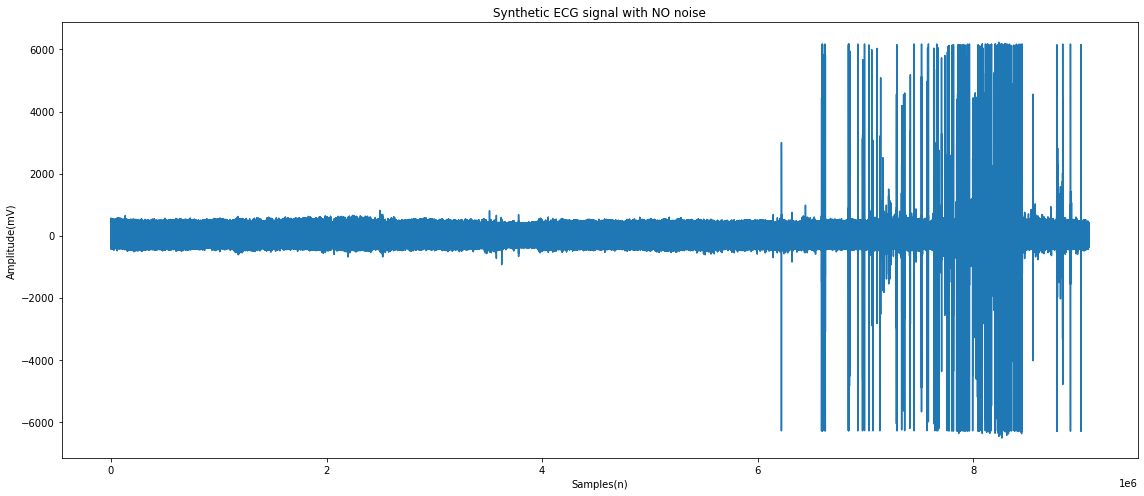

In [15]:
fig, axs = plt.subplots(1,1,figsize =(16,7),tight_layout = True)
plt.plot(df['ecg_0'])
plt.title('Synthetic ECG signal with NO noise')
plt.xlabel('Samples(n)')
plt.ylabel('Amplitude(mV)')
plt.show()

In [16]:
# List of starting points (remember, a 5-minute snippet is 300,000 readings)
snippets = [0, 12500000, 18000000, 21000000, 31000000]

In [33]:
# Cycle through the snippet start time list and save snippets as new feather files in new snippet folders
N = 300000
# Not a great name ;  nb_samples woudl be more explicit

# for snip, count in zip(snippets, range(len(snippets))):
for snip, count in enumerate(snippets):  # use enumerate when you want to access the index of the iteration  
    c = str(count).zfill(3) #Pad the count with leading zeros
#     filepath = patient_path + '\\Snippet' + c
    snippet_name = f"Snippet{c}" # Better way to do string manipulation
    filepath = os.path.join(patient_path,snippet_name)
    try:
        os.mkdir(filepath) # This step will fail if the folder already exists!!!
    except:
        print("File already exists: rewriting data.  \n" + filepath)
    # Generally speaking you need to consider the case when the ecg has already been processed 
    # and what to do with the existing files
        
    write_meta(snip, count, 'ecg_0', N, filepath)
    write_snippet(df[snip:(snip+N)], filepath)
    
    print(snip, count)

File already exists: rewriting data.  
/Volumes/GoogleDrive/.shortcut-targets-by-id/1sZgDE1M3o-bDINfAQYEXl_vqsKs03WxD/Molecool/Databases/Database1/S0432/holter/Snippet000
0 0
File already exists: rewriting data.  
/Volumes/GoogleDrive/.shortcut-targets-by-id/1sZgDE1M3o-bDINfAQYEXl_vqsKs03WxD/Molecool/Databases/Database1/S0432/holter/Snippet12500000
1 12500000
File already exists: rewriting data.  
/Volumes/GoogleDrive/.shortcut-targets-by-id/1sZgDE1M3o-bDINfAQYEXl_vqsKs03WxD/Molecool/Databases/Database1/S0432/holter/Snippet18000000
2 18000000
File already exists: rewriting data.  
/Volumes/GoogleDrive/.shortcut-targets-by-id/1sZgDE1M3o-bDINfAQYEXl_vqsKs03WxD/Molecool/Databases/Database1/S0432/holter/Snippet21000000
3 21000000
File already exists: rewriting data.  
/Volumes/GoogleDrive/.shortcut-targets-by-id/1sZgDE1M3o-bDINfAQYEXl_vqsKs03WxD/Molecool/Databases/Database1/S0432/holter/Snippet31000000
4 31000000


<AxesSubplot:>

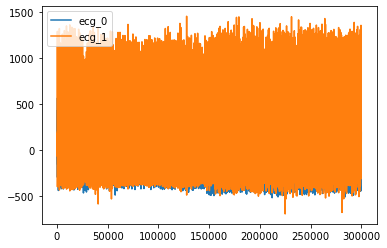

In [29]:
# Check that the feather file is ok
# This is dangerous .. filepath is the last value in the loop 
# It works but is shady 

# test = pd.read_feather(filepath + '\\MSNIP.ftr')
test = pd.read_feather(os.path.join(filepath,'MSNIP.ftr'))
test.plot()